# Stock Performance Prediction - Exploratory Analysis

This notebook demonstrates the end-to-end process of:
1. Loading and preprocessing stock data
2. Feature engineering
3. Model training and evaluation
4. Results analysis

In [17]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from src.data.data_loader import StockDataLoader
from src.data.feature_engineering import FeatureGenerator
from src.models.train import ModelTrainer

# Set plot style
plt.style.use('default')
sns.set_theme()
%matplotlib inline

## 1. Load Data

First, we'll load historical data for a subset of S&P 500 stocks. For demonstration purposes, we'll use a small subset of stocks to keep the analysis manageable.

In [18]:
# Initialize data loader
data_loader = StockDataLoader(start_date="2010-01-01")

# Get S&P 500 symbols
symbols = data_loader.get_sp500_symbols()
print(f"Number of S&P 500 symbols: {len(symbols)}")

# Load data for a subset of symbols (for demonstration)
sample_symbols = symbols[:10]  # Use first 10 symbols
stock_data, sp500_data = data_loader.prepare_training_data(sample_symbols)

print(f"\nStock data shape: {stock_data.shape}")
print(f"S&P 500 data shape: {sp500_data.shape}")

Loading S&P 500 symbols from local file: data/raw/sp500_symbols.csv
Number of S&P 500 symbols: 503
Preparing training data...
Loading stock data for ^GSPC from local file: data/raw/^GSPC_data.csv
Loading stock data for MMM from local file: data/raw/MMM_data.csv
Loading stock data for AOS from local file: data/raw/AOS_data.csv
Loading stock data for ABT from local file: data/raw/ABT_data.csv
Loading stock data for ABBV from local file: data/raw/ABBV_data.csv
Loading stock data for ACN from local file: data/raw/ACN_data.csv
Loading stock data for ADBE from local file: data/raw/ADBE_data.csv
Loading stock data for AMD from local file: data/raw/AMD_data.csv
Loading stock data for AES from local file: data/raw/AES_data.csv
Loading stock data for AFL from local file: data/raw/AFL_data.csv
Loading stock data for A from local file: data/raw/A_data.csv
Prepared training data with 10 stocks

Stock data shape: (37996, 8)
S&P 500 data shape: (3875, 8)


## 2. Data Exploration

Let's explore the data to understand its structure and characteristics.

In [19]:
# Display sample of stock data
print("Sample of stock data:")
display(stock_data.head())

# Display sample of S&P 500 data
print("\nSample of S&P 500 data:")
display(sp500_data.head())

Sample of stock data:


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol
Date,,,,,,,,
2010-01-04 00:00:00-05:00,43.393160,43.581167,43.173817,43.356606,3640265,0.0,0.0,MMM
2010-01-05 00:00:00-05:00,43.241700,43.466266,42.667233,43.085030,3405012,0.0,0.0,MMM
2010-01-06 00:00:00-05:00,43.805742,44.181756,43.612512,43.696068,6301126,0.0,0.0,MMM
2010-01-07 00:00:00-05:00,43.513285,43.743074,42.886595,43.727406,5346240,0.0,0.0,MMM
2010-01-08 00:00:00-05:00,43.706521,44.035534,43.502845,44.035534,4073337,0.0,0.0,MMM



Sample of S&P 500 data:


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol
Date,,,,,,,,
2010-01-04 00:00:00-05:00,1116.560059,1133.869995,1116.560059,1132.989990,3991400000,0.0,0.0,^GSPC
2010-01-05 00:00:00-05:00,1132.660034,1136.630005,1129.660034,1136.520020,2491020000,0.0,0.0,^GSPC
2010-01-06 00:00:00-05:00,1135.709961,1139.189941,1133.949951,1137.140015,4972660000,0.0,0.0,^GSPC
2010-01-07 00:00:00-05:00,1136.270020,1142.459961,1131.319946,1141.689941,5270680000,0.0,0.0,^GSPC
2010-01-08 00:00:00-05:00,1140.520020,1145.390015,1136.219971,1144.979980,4389590000,0.0,0.0,^GSPC


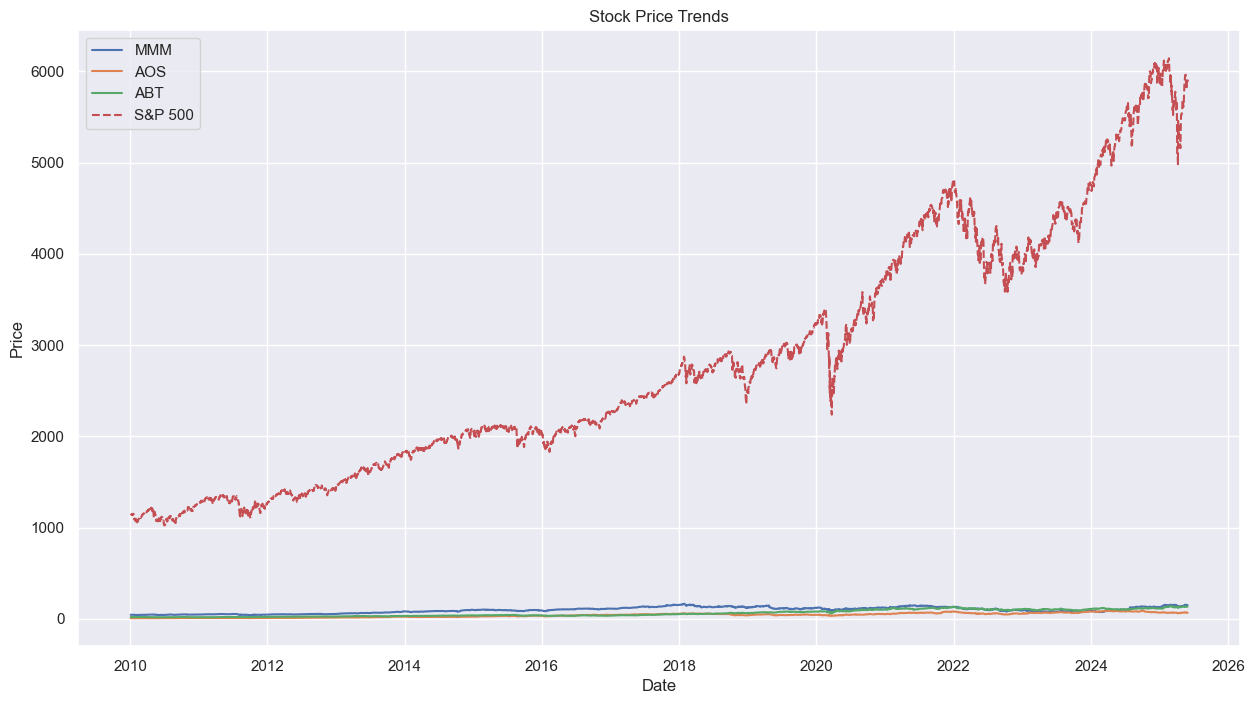

In [20]:
# Plot price trends for a few stocks
plt.figure(figsize=(15, 8))
for symbol in sample_symbols[:3]:  # Plot first 3 stocks
    stock_prices = stock_data[stock_data['Symbol'] == symbol]['Close']
    plt.plot(stock_prices.index, stock_prices.values, label=symbol)

plt.plot(sp500_data.index, sp500_data['Close'], label='S&P 500', linestyle='--')
plt.title('Stock Price Trends')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## 3. Feature Engineering

Now, let's generate technical indicators and other features for our model.

In [21]:
from src.data.feature_engineering import FeatureGenerator

# Initialize feature generator
feature_generator = FeatureGenerator()

# Generate features
df = feature_generator.prepare_features(stock_data, sp500_data)

print(f"Data shape after feature engineering: {df.shape}")
print("\nFeature columns:")
print(df.columns.tolist())

Removing future data columns to prevent leakage: ['Future_Returns_5d', 'Future_Returns_5d_SP500']
Dataset shape before NaN handling: (37996, 86)
NaN counts by column:
Volatility_50d        500
Returns_50d           500
Log_Return_50d        500
Price_Std_50d         490
Price_Momentum_50d    490
Price_Zscore_50d      490
BB_Std_50d            490
BB_Middle_50d         490
BB_Lower_50d          490
Price_MA_50d          490
dtype: int64
Rows dropped due to missing essential data: 10
Rows after ensuring sufficient historical data: 37446
Final dataset shape: (37446, 86)
Remaining NaN values: 0
Data shape after feature engineering: (37446, 86)

Feature columns:
['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Symbol', 'Returns_1d', 'Log_Return_1d', 'Returns_5d', 'Log_Return_5d', 'Returns_10d', 'Log_Return_10d', 'Returns_20d', 'Log_Return_20d', 'Returns_50d', 'Log_Return_50d', 'Volatility_5d', 'Volatility_10d', 'Volatility_20d', 'Volatility_50d', 'Volume_MA_5', 'Volu

Columns in df: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Symbol', 'Returns_1d', 'Log_Return_1d', 'Returns_5d', 'Log_Return_5d', 'Returns_10d', 'Log_Return_10d', 'Returns_20d', 'Log_Return_20d', 'Returns_50d', 'Log_Return_50d', 'Volatility_5d', 'Volatility_10d', 'Volatility_20d', 'Volatility_50d', 'Volume_MA_5', 'Volume_MA_20', 'Volume_Ratio', 'Volume_Delta', 'VWAP', 'Price_MA_5d', 'Price_Std_5d', 'Price_Momentum_5d', 'Price_Zscore_5d', 'Price_MA_10d', 'Price_Std_10d', 'Price_Momentum_10d', 'Price_Zscore_10d', 'Price_MA_20d', 'Price_Std_20d', 'Price_Momentum_20d', 'Price_Zscore_20d', 'Price_MA_50d', 'Price_Std_50d', 'Price_Momentum_50d', 'Price_Zscore_50d', 'Momentum_3d', 'Momentum_5d', 'Momentum_10d', 'RSI_5d', 'RSI_10d', 'RSI_20d', 'RSI_50d', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Middle_5d', 'BB_Std_5d', 'BB_Upper_5d', 'BB_Lower_5d', 'BB_Width_5d', 'BB_Middle_10d', 'BB_Std_10d', 'BB_Upper_10d', 'BB_Lower_10d', 'BB_Width_10d', 'BB_Middle_20d', 'BB_Std_2

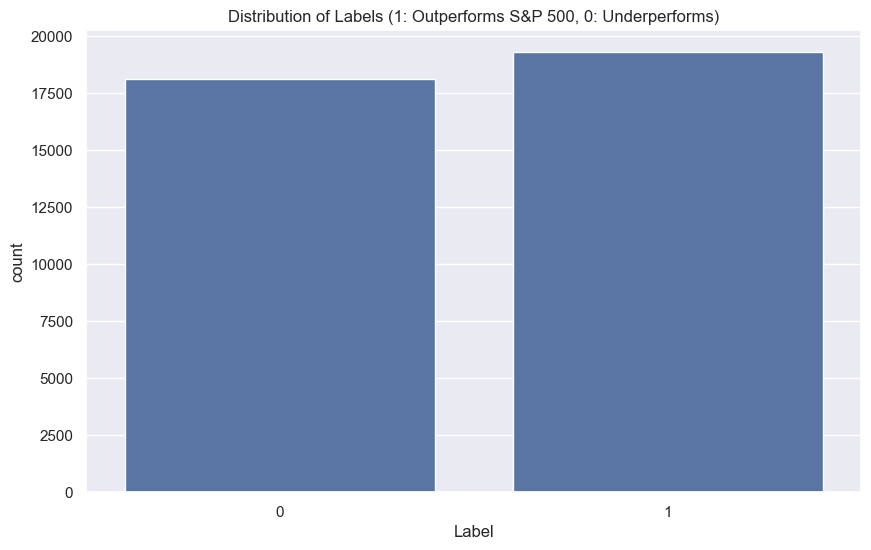

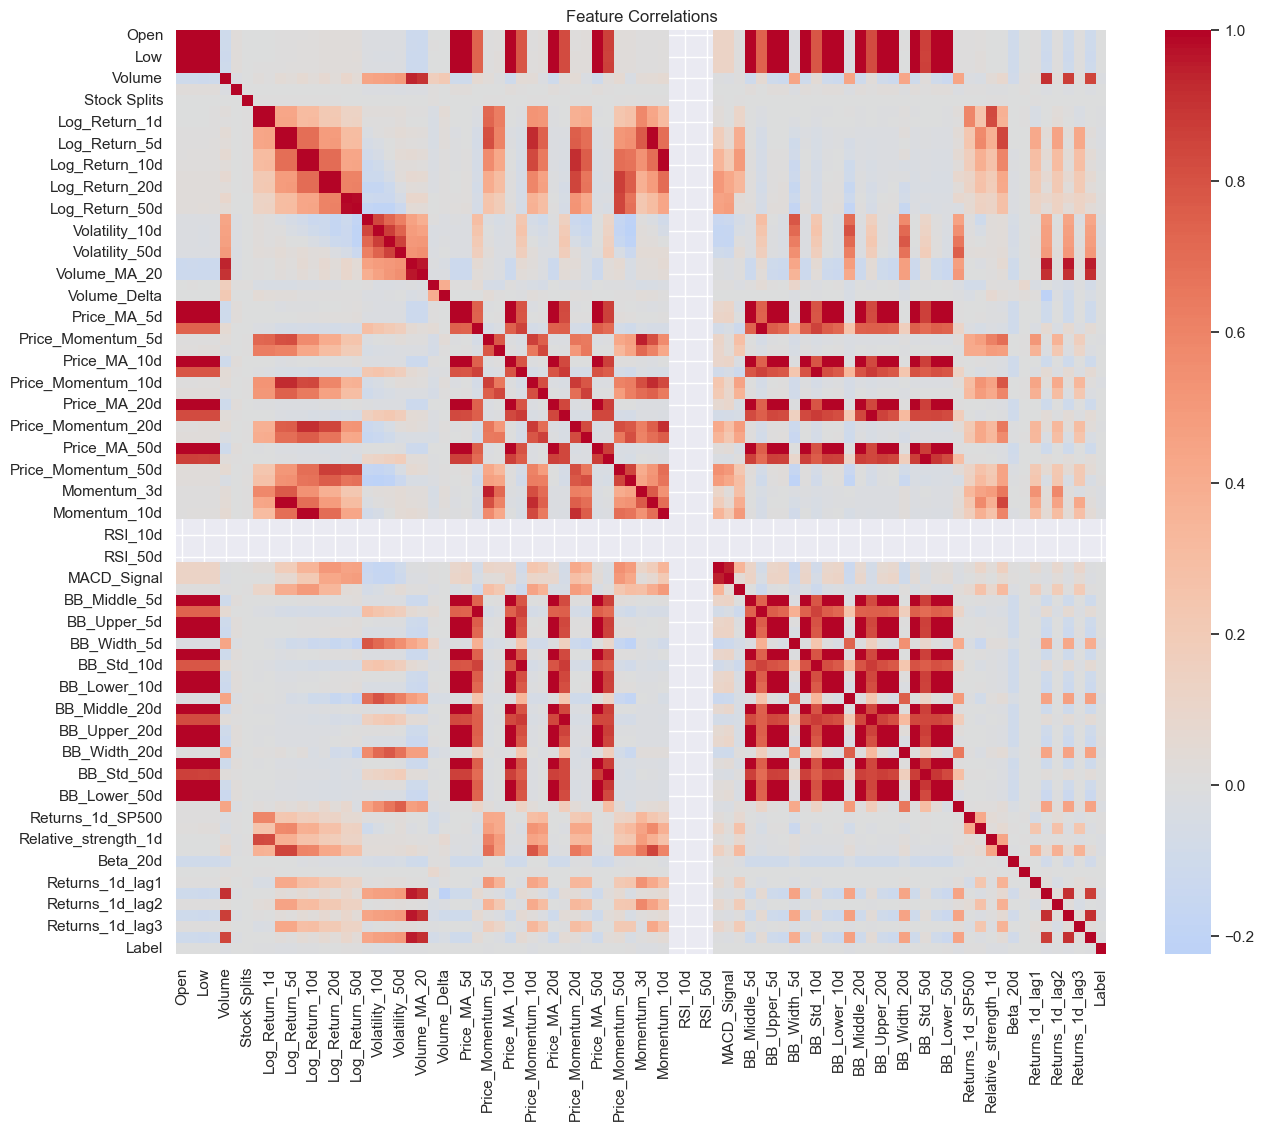

In [22]:
# Check available columns
print("Columns in df:", df.columns.tolist())

# Try to find the label column (case-insensitive)
label_col = None
for col in df.columns:
    if col.lower() == "label":
        label_col = col
        break
if label_col is None:
    raise ValueError("No column named 'Label' found in df. Available columns: {}".format(df.columns.tolist()))

# Plot distribution of labels
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x=label_col)
plt.title('Distribution of Labels (1: Outperforms S&P 500, 0: Underperforms)')
plt.show()

# Plot feature correlations
plt.figure(figsize=(15, 12))
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Feature Correlations')
plt.show()

## 3.1 Improving the Model

To improve the model, we will:
1. Check for class imbalance and apply resampling if needed.
2. Perform hyperparameter tuning using GridSearchCV.
3. Optionally, try a different model (e.g., XGBoost) if available.
4. Add more advanced features if necessary.

Let's start by checking for class imbalance.

In [ ]:
# Check for class imbalance
from collections import Counter
from imblearn.over_sampling import SMOTE

label_counts = Counter(df[label_col])
print("Label distribution:", label_counts)

# If imbalance is significant, apply SMOTE
imbalance_ratio = min(label_counts.values()) / max(label_counts.values())
if imbalance_ratio < 0.7:
    print("Applying SMOTE to balance classes...")
    smote = SMOTE(random_state=42)
    X = df.drop(columns=[label_col, 'Symbol', 'Date'], errors='ignore')
    y = df[label_col]
    X_res, y_res = smote.fit_resample(X, y)
    df_resampled = pd.DataFrame(X_res, columns=X.columns)
    df_resampled[label_col] = y_res
    print("Resampled label distribution:", Counter(y_res))
else:
    print("No significant imbalance detected.")
    df_resampled = df.copy()

In [ ]:
# Hyperparameter tuning for Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

X = df_resampled.drop(columns=[label_col, 'Symbol', 'Date'], errors='ignore')
y = df_resampled[label_col]

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)
best_rf = grid_search.best_estimator_

In [ ]:
# Optionally try XGBoost if available
try:
    from xgboost import XGBClassifier
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    param_grid_xgb = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2]
    }
    grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=3, scoring='f1', n_jobs=-1)
    grid_search_xgb.fit(X, y)
    print("XGBoost best parameters:", grid_search_xgb.best_params_)
    print("XGBoost best F1 score:", grid_search_xgb.best_score_)
    best_xgb = grid_search_xgb.best_estimator_
except ImportError:
    print("XGBoost not installed. Skipping XGBoost model.")

## 4. Model Training

Let's train our model and evaluate its performance.

Evaluation Metrics:
accuracy: 0.5235
precision: 0.5201
recall: 0.8667
f1: 0.6501


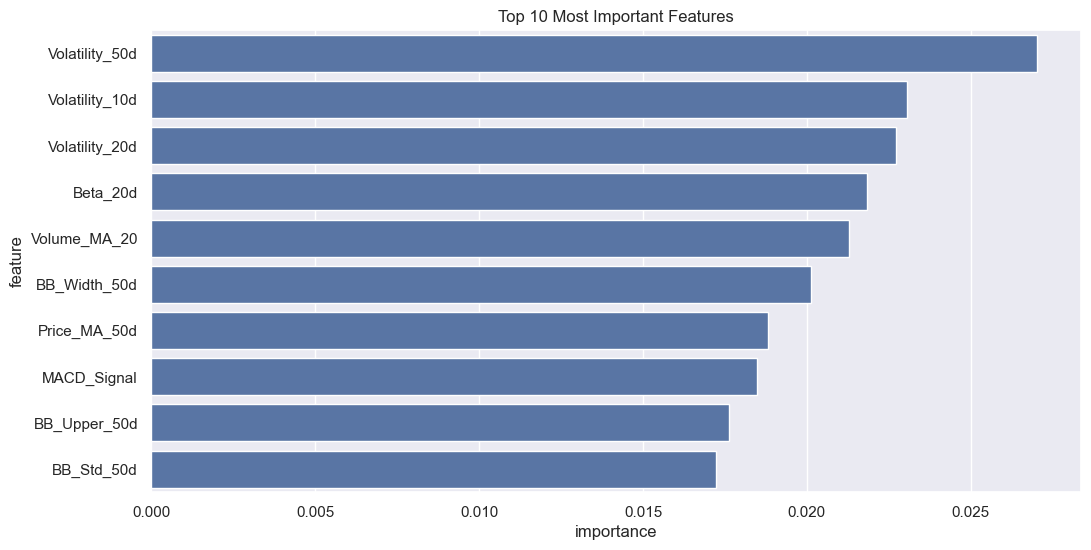

In [23]:
# Initialize model trainer
model_trainer = ModelTrainer()

# Train and evaluate model
results = model_trainer.train_and_evaluate(df)

# Print evaluation metrics
print("Evaluation Metrics:")
for metric, value in results['evaluation_metrics'].items():
    print(f"{metric}: {value:.4f}")

# Plot feature importance
feature_importance = results['training_results']['feature_importance']
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.show()

## 5. Model Analysis

Let's analyze the model's performance in more detail.

In [24]:
# Analyze predictions by stock
X, y = model_trainer.prepare_features(df)
X_train, X_test, y_train, y_test = model_trainer.train_test_split(X, y)

# Make predictions
X_test_scaled = model_trainer.scaler.transform(X_test)
y_pred = model_trainer.model.predict(X_test_scaled)
y_pred_proba = model_trainer.model.predict_proba(X_test_scaled)[:, 1]

# Create results dataframe
results_df = pd.DataFrame({
    'Symbol': df.iloc[X_test.index]['Symbol'],
    'Date': df.iloc[X_test.index].index,
    'Actual': y_test,
    'Predicted': y_pred,
    'Probability': y_pred_proba
})

# Calculate accuracy by stock
stock_accuracy = results_df.groupby('Symbol').apply(
    lambda x: (x['Actual'] == x['Predicted']).mean()
).sort_values(ascending=False)

print("\nAccuracy by Stock:")
print(stock_accuracy)

# Plot accuracy by stock
plt.figure(figsize=(12, 6))
stock_accuracy.plot(kind='bar')
plt.title('Model Accuracy by Stock')
plt.xlabel('Stock Symbol')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

IndexError: positional indexers are out-of-bounds

## 6. Conclusion

In this notebook, we have:
1. Loaded and preprocessed stock data from S&P 500
2. Generated technical indicators and market features
3. Trained a Random Forest model to predict stock performance
4. Evaluated the model's performance
5. Analyzed feature importance and stock-specific accuracy

The model shows promising results in predicting whether a stock will outperform the S&P 500 index over the next 5 trading days. The feature importance analysis reveals which technical indicators and market features are most predictive of stock performance.

# Use the best model found (Random Forest or XGBoost if better)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split data
X = df_resampled.drop(columns=[label_col, 'Symbol', 'Date'], errors='ignore')
y = df_resampled[label_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Choose best model
model = best_rf
try:
    if 'best_xgb' in locals() and grid_search_xgb.best_score_ > grid_search.best_score_:
        model = best_xgb
        print("Using XGBoost as the best model.")
    else:
        print("Using Random Forest as the best model.")
except:
    print("Using Random Forest as the best model.")

# Train and evaluate
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Print evaluation metrics
print("Evaluation Metrics:")
print("accuracy:", accuracy_score(y_test, y_pred))
print("precision:", precision_score(y_test, y_pred))
print("recall:", recall_score(y_test, y_pred))
print("f1:", f1_score(y_test, y_pred))

# Feature importance plot
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    features = X.columns
    feature_importance = pd.DataFrame({'feature': features, 'importance': importances})
    feature_importance = feature_importance.sort_values(by='importance', ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
    plt.title('Top 10 Most Important Features')
    plt.show()